# Trabalho 1 RP36O 2020/2 (UTFPR)
## Autores: Rafael Rampim Soratto e Venancius


dependencias:
```shell
pip install -r ./requirements.txt
```

In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd
import numpy
import json
import mne
import matplotlib
from scipy.signal import stft
import scipy
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics

Preparação do dataset do trabalho

In [2]:
# bloco de declaração dos identificadores de download (google drive) e setup
dataset_ids = {
    1: '1ym3JqI4_ZYNSBLxoF1vNxI5Hsgur_tha',
    2: '1tJ5tHbE-2jwr0gA33Gd873lRPao-e4dF',
    3: '1tXdpY-mser01POaP6Qwixny6LjsXXoXB',
    4: '1T00cliWp5yqqbbWZ7-rf2X4tOUQ-PvIQ',
    5: '1CYsBFMul9zB_vCy0XD7XVfKUl8vihDYZ',
    6: '1io6jdALBKeopELWXahPzuAi6EfYDgviW',
    7: '1YDkheRDPNDR1ujsqqC_SY6cebWHkw9Xt',
    8: '1jjoQJFDCi7O9Q-iaReAPpQnxC-HIKpQi',
}
label_id = '1mD5MXoh6tfQJFXIvdw2MQsEu6vZka6C0'
desc = '14kYNBZYdttqmSS_Vz6Bm_ztG9Uw1MC0y'
DS = 6 #dataset

In [3]:
# get data
gdd.download_file_from_google_drive(file_id=dataset_ids[DS],
                                    dest_path='files/data.npy',
                                    showsize=True)
# download do arquivo de marcações
gdd.download_file_from_google_drive(file_id=label_id,
                                    dest_path='files/labels.npy', showsize=True)

# download do arquivo de descrição
gdd.download_file_from_google_drive(file_id=desc,
                                    dest_path='files/descriptor.json',
                                    showsize=True)

In [4]:
X = numpy.load('files/data.npy')
y = numpy.load('files/labels.npy')
desc_file = open('files/descriptor.json')
descriptor = json.loads(desc_file.read())
desc_file.close()
print('Estruturas => dados', X.shape, 'labels', y.shape)

Estruturas => dados (125, 257, 1205) labels (125,)


# Estrutura 

Os dados estão estruturados em numpy arrays.

# Shape
O "shape" (125, 257, 1205) para os dados EEG de X, significa que existem 125 trials (tradução aceitável: ensaio, julgamento), 257 channels que representam os eletrodos e 1205 dados que representam o potencial mensurado em ponto flutuante. Este é um array com três dimensões.

O "shape" (125,) para os dados de labels ou marcadores y, apresentam qual é o eletrodo respectivo a cada trial. Os labels estão com valores numéricos como é mostrado a seguir, o que facilita o processamento, mas não é intuitivo.

Desta forma, foi preparado um arquivo de descrição no qual é possível saber qual é o rótulo correto do correspondente "número", além de outras informações como a taxa de amostragem (sampling rate), idade, tipo do cabelo (curto, médio ou comprido), sexo, tamanho da touca e se é destro ou canhoto. A princípio, imaginamos que estas informações não são tão importantes, mas problemas na experimentação podem ter culpa por um desses motivos, como por exemplo, o tamanho do cabelo. Veja os dados do voluntário escolhido:


In [5]:
print('Características do voluntário:', descriptor[str(DS)])
print('\nRótulos:', descriptor['frequencies'])
print('\nTaxa de amostragem:', descriptor['sampling_rate'])

Características do voluntário: {'age': '31', 'capsize': 'Adult Medium', 'gender': 'Female', 'hairtype': 'Thick', 'handedness': 'Right'}

Rótulos: {'1': 6.66, '2': 7.5, '3': 8.57, '4': 10.0, '5': 12.0}

Taxa de amostragem: 250


# Atributos
Como é possível visualizar as características do voluntário são:
```json
{
    idade: 31,
    tamanho_cabeca: Médio,
    gênero: Mulher,
    tipo_cabelo: Grosso,
    lateralidade: destro,
}
```

# Sampling rate
Os dados dos voluntários do trabalho não estão balanceados em número, portanto deve-se re-calcular a taxa de amostragem para utilizar vetores não esparsos.

In [6]:
# quantidade_de_dados / tempo_do_trial
descriptor['sampling_rate'] = X.shape[-1] / 5
sfreq = descriptor['sampling_rate']

X = X[:,:256,:]
ch_names = X.shape[1]
ch_types = 'eeg'

# objeto com o nome dos canais pelo modelo da touca utilizada
montage = mne.channels.make_standard_montage('EGI_256')

info = mne.create_info(montage.ch_names, sfreq, ch_types)
info.set_montage(montage)
info

<Info | 8 non-empty values
 bads: []
 ch_names: E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, ...
 chs: 256 EEG
 custom_ref_applied: False
 dig: 259 items (3 Cardinal, 256 EEG)
 highpass: 0.0 Hz
 lowpass: 120.5 Hz
 meas_date: unspecified
 nchan: 256
 projs: []
 sfreq: 241.0 Hz
>

In [7]:
events = [[i, 0, e] for i, e in enumerate(y)]
obj = mne.EpochsArray(X, info, events=numpy.array(events))

125 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


In [8]:
obj

<EpochsArray  |   125 events (all good), 0 - 4.99585 sec, baseline off, ~294.8 MB, data loaded,
 '1': 25
 '2': 25
 '3': 30
 '4': 25
 '5': 20>

# Filtragem CAR 
Consiste na subtração ponto a ponto do sinal coletado em um dos eletrodos pela média pontual dos sinais coletados pelos 16 eletrodos. Na filtragem CAR considera-se que a média de todos os eletrodos é uma estimativa da atividade elétrica no eletrodo de referência, e essa atividade elétrica afeta igualmente as gravações de todos os outros eletrodos.

Quando um ruído afeta a atividade elétrica coletada em todos os eletrodos, sendo esses eletrodos uniformemente espaçados por todo o córtex cerebral, esse ruído provavelmente é oriundo de alguma mudança na atividade elétrica do eletrodo de referência. Calculando-se a média dos sinais coletados
em todos os 16 eletrodos, um novo sinal é encontrado e esse novo sinal é transformado na referência. O sinal coletado por cada eletrodo é então subtraído pelo novo sinal de referência, retirando aquilo que é comum a todos eles. Quando o número de eletrodos utilizados na coleta dos dados é igual ou maior que 16, sendo esses eletrodos uniformemente espaçados na cabeça, a abordagem CAR leva a uma filtragem do sinal EEG quase ideal (GARCIA-MOLINA; ZHU, 2011).

Referências

https://pdfs.semanticscholar.org/cb26/23303f2b647a15f8332877d574eb75690342.pdf

In [9]:
# Seleciona eletrodos
selected_electrodes = ['E115', 'E116', 'E122', 'E123', 'E124', 'E125','E135', 'E137', 'E138', 'E149', 'E150', 'E157','E158', 'E159', 'E167', 'E147']
epoch_ex = obj.copy().pick_channels(selected_electrodes)
epoch_ex

<EpochsArray  |   125 events (all good), 0 - 4.99585 sec, baseline off, ~18.6 MB, data loaded,
 '1': 25
 '2': 25
 '3': 30
 '4': 25
 '5': 20>

In [10]:
print('Epoch array')
print(obj.get_data().shape)
print('Epoch array filtrando eletrodos')
print(epoch_ex.get_data().shape)

Epoch array
(125, 256, 1205)
Epoch array filtrando eletrodos
(125, 16, 1205)


In [11]:
epoch_ex.save('files/unfiltered_epo.fif', overwrite=True)

Overwriting existing file.


# Etapa de Pre processamento

In [12]:
matplotlib.rcParams['figure.figsize'] = [8., 6.]

e = '1'

trial = 3

In [13]:
# Carrega o epoch sem filtros
epochs = mne.read_epochs('files/unfiltered_epo.fif')

Reading files/unfiltered_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    4995.85 ms
        0 CTF compensation matrices available
125 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


    Using multitaper spectrum estimation with 7 DPSS windows


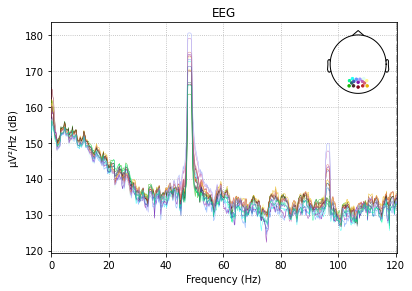

In [14]:
# Dados sem nenhum filtro, é possível observar o pico próximo a frequencia 50hz causado pela rede eletrica
epochs[e][trial].plot_psd()
print('')

Setting up band-pass filter from 4 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 399 samples (1.656 sec)

    Using multitaper spectrum estimation with 7 DPSS windows


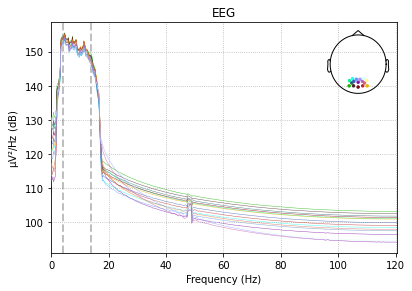

In [15]:
#Remove frenquencias abaixo de 4hz e acima de 14hz
epochs.filter(l_freq=4.0, h_freq=14.0)
epochs[e][trial].plot_psd()
print('')

    Using multitaper spectrum estimation with 7 DPSS windows


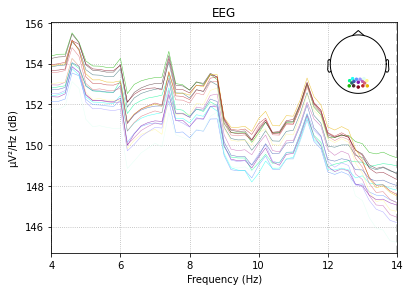

In [16]:
# Grafico apenas das frequencias de interesse (de 4hz até 14hz)
epochs[e][trial].plot_psd(fmin=4.0, fmax=14.0)
print('')

In [17]:
epo_ref = mne.set_eeg_reference(epochs, ref_channels=['E116', 'E125', 'E138'])
epochs = epo_ref[0]

EEG channel type selected for re-referencing
Applying a custom EEG reference.


    Using multitaper spectrum estimation with 7 DPSS windows


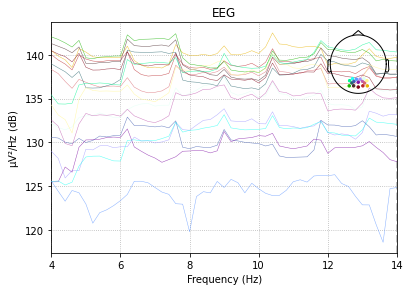

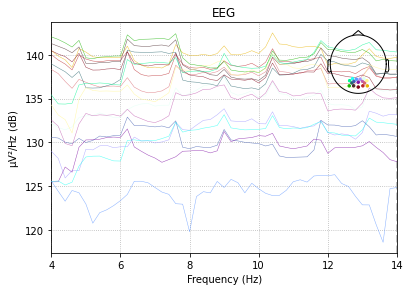

In [18]:
epochs[e][15].plot_psd(fmin=4.0, fmax=14.0)

In [19]:
epochs.save('files/filtered_epo.fif', overwrite=True)

Overwriting existing file.


### set_eeg_reference METHOD

In [20]:
%matplotlib inline
epochs = mne.read_epochs('files/filtered_epo.fif')
data = epochs.get_data()
data.shape

Reading files/filtered_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    4995.85 ms
        0 CTF compensation matrices available
125 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


(125, 16, 1205)

In [21]:
epoch_welch_12 = epochs.copy()
epoch_welch_12.filter(l_freq=11., h_freq=13.)
epoch_welch_10 = epochs.copy()
epoch_welch_10.filter(l_freq=9., h_freq=11.)
epoch_welch_8_57 = epochs.copy()
epoch_welch_8_57.filter(l_freq=8., h_freq=9.)
epoch_welch_7_50 = epochs.copy()
epoch_welch_7_50.filter(l_freq=7.1, h_freq=7.9)
epoch_welch_6_66 = epochs.copy()
epoch_welch_6_66.filter(l_freq=6.33, h_freq=7.)

epoch_array = [epoch_welch_12, epoch_welch_10, epoch_welch_8_57, epoch_welch_7_50, epoch_welch_6_66]

welch_array = []
for i in range(len(epoch_array)):
    epoch_welch, freqs = mne.time_frequency.psd_welch(epoch_array[i], n_per_seg=32, n_overlap=16)
    freqs, epoch_welch = scipy.signal.welch(epoch_welch, fs=241, nperseg=32, noverlap=16)
    w = numpy.abs(epoch_welch) ** 2

    W = w
    w.shape
    welch_array.append(W)
    print(w.shape)

Setting up band-pass filter from 11 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 11.00
- Lower transition bandwidth: 2.75 Hz (-6 dB cutoff frequency: 9.62 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 289 samples (1.199 sec)

Setting up band-pass filter from 9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 2.25 Hz (-6 dB cutoff frequency: 7.88 Hz)
- Upper passband edge: 11.00 Hz
- Upper transition bandwidth: 2.75 Hz (-6 dB cutoff frequency: 12.38 Hz)
- 

Média

In [22]:
feature_array = []
for i in range(len(welch_array)):
    fmn = numpy.mean(welch_array[i], axis=-1)
    print('FMN:', fmn.shape)

    # Max - 2*
    mx = numpy.amax(welch_array[i], axis=-1)
    print('MAX:', mx.shape)

    # Min - 3*
    mn = numpy.amin(welch_array[i], axis=-1)
    print('MIN:', mn.shape)

    # Standard deviation (SD) - 4*
    sd = numpy.std(welch_array[i], axis=-1)
    print('SD:', sd.shape)

    # Root mean square - 5*
    rms = numpy.sqrt(numpy.mean(welch_array[i], axis=-1))
    print('RMS:', rms.shape)

    # Root of sum of squares - 6*
    rss = numpy.sqrt(numpy.sum(welch_array[i], axis=-1))
    print('RSS:', rss.shape)

    # Kurtosis 7 *
    kur = scipy.stats.kurtosis(welch_array[i], axis=-1)
    print('KUR:', kur.shape)

    # Skewness 8
    skw = scipy.stats.skew(welch_array[i], axis=-1)
    print('SKW:', skw.shape)
    
    final_features = list()
    initial_features = [fmn, mx, mn, sd, rms, rss,]
    for feature in (initial_features):
        final_features.append(feature)
    feature_array.append(numpy.concatenate(final_features, axis=-1))

FMN: (125, 16)
MAX: (125, 16)
MIN: (125, 16)
SD: (125, 16)
RMS: (125, 16)
RSS: (125, 16)
KUR: (125, 16)
SKW: (125, 16)
FMN: (125, 16)
MAX: (125, 16)
MIN: (125, 16)
SD: (125, 16)
RMS: (125, 16)
RSS: (125, 16)
KUR: (125, 16)
SKW: (125, 16)
FMN: (125, 16)
MAX: (125, 16)
MIN: (125, 16)
SD: (125, 16)
RMS: (125, 16)
RSS: (125, 16)
KUR: (125, 16)
SKW: (125, 16)
FMN: (125, 16)
MAX: (125, 16)
MIN: (125, 16)
SD: (125, 16)
RMS: (125, 16)
RSS: (125, 16)
KUR: (125, 16)
SKW: (125, 16)
FMN: (125, 16)
MAX: (125, 16)
MIN: (125, 16)
SD: (125, 16)
RMS: (125, 16)
RSS: (125, 16)
KUR: (125, 16)
SKW: (125, 16)


### Criando o vetor de características X

In [23]:
X = numpy.concatenate(final_features, axis=-1)
print('Shape dos dados:', X.shape)

Shape dos dados: (125, 96)


## Adaptação do vetor de labels y
Temos que adaptar o vetor de labels para ficar do mesmo tamanho (mesma quantidade de linhas) que o vetor de dados X

In [24]:
y = numpy.load('files/labels.npy')
print('Shape original dos labels', y.shape)

size = int(welch_array[0].shape[0] / y.shape[0])
Y = numpy.concatenate([y for i in range(size)])
print('Shape final dos labels', y.shape)

Shape original dos labels (125,)
Shape final dos labels (125,)


In [ ]:
for count in range(1000):
    for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
        for gamma in [10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]:
            for C in [0.01, 0.1, 1, 10, 100, 1000]:
                results = []
                for i in range(len(feature_array)):
                    X_train, X_test, y_train, y_test = train_test_split(
                        feature_array[i], Y, train_size=0.7, shuffle=True)
                    clf = SVC(kernel=kernel,gamma=0.0001, C=1)
                    clf = clf.fit(X_train, y_train)
                    res = clf.predict(X_test)
                    results.append(res)
                tot_hit = sum([1 for i in range(len(res)) if (numpy.argmax(numpy.bincount([n[0] for n in results]))) == y_test[i]])
                acc = tot_hit / X_test.shape[0] * 100
                if (acc >= 36):
                    print('Kernel:{} | Gamma:{} e C:{} | Accuracy: {:.2f}% | {}/{}'.format(
                        kernel, gamma, C, acc, tot_hit, X_test.shape[0])
                    )

Kernel:rbf | Gamma:1e-06 e C:1000 | Accuracy: 36.84% | 14/38
Kernel:sigmoid | Gamma:0.001 e C:0.1 | Accuracy: 36.84% | 14/38
Kernel:sigmoid | Gamma:0.001 e C:10 | Accuracy: 39.47% | 15/38
Kernel:rbf | Gamma:1e-06 e C:1000 | Accuracy: 39.47% | 15/38
Kernel:sigmoid | Gamma:0.001 e C:100 | Accuracy: 36.84% | 14/38
Kernel:poly | Gamma:1e-06 e C:0.1 | Accuracy: 36.84% | 14/38
Kernel:rbf | Gamma:0.001 e C:100 | Accuracy: 39.47% | 15/38
Kernel:sigmoid | Gamma:0.1 e C:0.1 | Accuracy: 39.47% | 15/38
Kernel:sigmoid | Gamma:1e-06 e C:10 | Accuracy: 36.84% | 14/38
Kernel:linear | Gamma:0.0001 e C:0.1 | Accuracy: 36.84% | 14/38
Kernel:linear | Gamma:1e-06 e C:1000 | Accuracy: 39.47% | 15/38
Kernel:poly | Gamma:0.1 e C:10 | Accuracy: 36.84% | 14/38
Kernel:poly | Gamma:0.001 e C:0.01 | Accuracy: 42.11% | 16/38
Kernel:rbf | Gamma:1e-05 e C:0.1 | Accuracy: 36.84% | 14/38
Kernel:rbf | Gamma:1e-05 e C:1000 | Accuracy: 36.84% | 14/38
Kernel:sigmoid | Gamma:10 e C:10 | Accuracy: 36.84% | 14/38
Kernel:sigmo

Kernel:linear | Gamma:0.0001 e C:1000 | Accuracy: 42.11% | 16/38
Kernel:sigmoid | Gamma:0.001 e C:100 | Accuracy: 39.47% | 15/38
Kernel:linear | Gamma:0.01 e C:1 | Accuracy: 36.84% | 14/38
Kernel:linear | Gamma:0.0001 e C:10 | Accuracy: 44.74% | 17/38
Kernel:poly | Gamma:1e-05 e C:1000 | Accuracy: 36.84% | 14/38
Kernel:sigmoid | Gamma:1 e C:10 | Accuracy: 36.84% | 14/38
Kernel:linear | Gamma:0.01 e C:100 | Accuracy: 36.84% | 14/38
Kernel:poly | Gamma:10 e C:1 | Accuracy: 39.47% | 15/38
Kernel:poly | Gamma:0.01 e C:1 | Accuracy: 36.84% | 14/38
Kernel:poly | Gamma:0.0001 e C:1000 | Accuracy: 36.84% | 14/38
Kernel:sigmoid | Gamma:1e-05 e C:100 | Accuracy: 36.84% | 14/38
Kernel:linear | Gamma:10 e C:100 | Accuracy: 36.84% | 14/38
Kernel:linear | Gamma:10 e C:1000 | Accuracy: 36.84% | 14/38
Kernel:poly | Gamma:0.1 e C:0.01 | Accuracy: 36.84% | 14/38
Kernel:sigmoid | Gamma:0.01 e C:1 | Accuracy: 36.84% | 14/38
Kernel:sigmoid | Gamma:0.0001 e C:1000 | Accuracy: 36.84% | 14/38
Kernel:sigmoid |

Kernel:sigmoid | Gamma:1e-06 e C:0.1 | Accuracy: 36.84% | 14/38
Kernel:poly | Gamma:10 e C:0.01 | Accuracy: 36.84% | 14/38
Kernel:poly | Gamma:0.01 e C:100 | Accuracy: 36.84% | 14/38
Kernel:sigmoid | Gamma:0.001 e C:10 | Accuracy: 36.84% | 14/38
Kernel:sigmoid | Gamma:1e-05 e C:0.1 | Accuracy: 36.84% | 14/38
Kernel:linear | Gamma:1 e C:1000 | Accuracy: 36.84% | 14/38
Kernel:linear | Gamma:0.1 e C:100 | Accuracy: 36.84% | 14/38
Kernel:linear | Gamma:1e-06 e C:0.1 | Accuracy: 39.47% | 15/38
Kernel:poly | Gamma:0.1 e C:10 | Accuracy: 39.47% | 15/38
Kernel:sigmoid | Gamma:0.001 e C:100 | Accuracy: 36.84% | 14/38
Kernel:sigmoid | Gamma:0.0001 e C:1 | Accuracy: 36.84% | 14/38
Kernel:sigmoid | Gamma:1e-05 e C:1 | Accuracy: 36.84% | 14/38
Kernel:poly | Gamma:1e-06 e C:1 | Accuracy: 36.84% | 14/38
Kernel:sigmoid | Gamma:0.0001 e C:0.01 | Accuracy: 39.47% | 15/38
Kernel:linear | Gamma:1e-06 e C:1 | Accuracy: 36.84% | 14/38
Kernel:linear | Gamma:1e-06 e C:10 | Accuracy: 36.84% | 14/38
Kernel:poly